<h1 align="center">KDD Cup 1999 Model</h1>

<hr style="border-top: 2px solid #444">

## Development Environment
In this section, the development environment for this Jupyter notebook project is prepared by collecting Python dependencies, importing libraries, and configuring the runtime environment.

### Python Dependencies
External Python dependencies are collected through the [Pipenv](https://pypi.org/project/pipenv/) package manager since it supports dependency lock-files. In the following script, `pipenv` and its transitive dependencies are installed from `pipenv-requirements.txt` and then the notebook's dependencies are installed from `Pipfile` and `Pipfile.lock`.

In [1]:
#!pip install -r pipenv-requirements.txt
#!pipenv install

### Library Imports
All internal standard libraries and external libraries are imported here, with some stated dependency versions.

In [2]:
import gzip
import math
import os
import re
import sys
from enum import Enum
from io import StringIO
from time import time

import matplotlib.pyplot as pyplot
import numpy
import pandas
import requests
import tensorflow
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

### Configure PRNG Seed
Numpy, Tensorflow, and SciKit rely on [pseudorandom number generators](https://en.wikipedia.org/wiki/Pseudorandom_number_generator) as their internal source for randomness. To guarantee deterministic behaviour and reproducible results for this notebook's execution, an arbitrary seed is configured.

In [3]:
PRNG_SEED = 42

numpy.random.seed(PRNG_SEED)
tensorflow.random.set_seed(PRNG_SEED)

<hr style="border-top: 2px solid #444">

## I. Data Importation

Source: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In [4]:
# create 'data' cache directory
if not os.path.exists('data'):
    os.path.makedirs('data')

### Fetch Column Types: Categorical vs Continuous

In [5]:
DATASET_COLUMNS_FILE = os.path.join("data", "kddcup1999_columns.txt")

if not os.path.exists(DATASET_COLUMNS_FILE):
    with requests.get("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names") as request:
        with open(DATASET_COLUMNS_FILE, 'wb') as file:
            file.write(request.content)

### Fetch Labeled CSV Dataset

In [6]:
DATASET_URL = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz"
DATASET_FILE = os.path.join("data", "kddcup1999.csv")

# download dataset if not already cached
if not os.path.exists(DATASET_FILE):
    with requests.get(DATASET_URL) as response:
        if response.status_code != 200:
            raise RuntimeError(f"failed to download dataset: {DATASET_URL}")
        # decompress content
        with open(DATASET_FILE, 'wb') as file:
            file.write(gzip.decompress(response.content))

### Load Column Types

In [7]:
ColumnType = Enum('ColumnType', 'SYMBOLIC CONTINUOUS')
column_types = {}

with open(DATASET_COLUMNS_FILE, 'r') as file:
    column_labels: str = file.read()

column_regex: re.Pattern = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
for column_type in column_labels.splitlines()[1:]:
    match = column_regex.match(column_type)
    column_types[match.group("column_name")] = ColumnType[match.group("data_type").upper()]

### Load CSV Dataset

In [8]:
dataframe = pandas.read_csv(
    # file to import from
    DATASET_FILE,
    # important to specify the CSV file contains no headers
    # otherwise, the first record is interpreted as a header
    header = None,
)
dataframe.columns = [*column_types.keys(), "outcome"]

pandas.set_option('display.max_rows', 10)
dataframe

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


<hr style="border-top: 2px solid #444">

## II. Inspecting Dataset

### Normal vs Intrusions

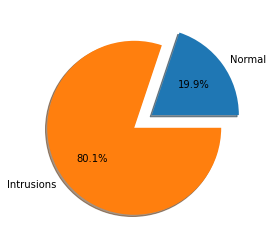

In [9]:
type_frequencies = dataframe['outcome'].value_counts()
normal_frequency = type_frequencies['normal.']
intrusion_frequency = sum([count for outcome_type, count in type_frequencies.iteritems() if outcome_type != 'normal.'])

figure = pyplot.figure()
pyplot.pie(
    [normal_frequency, intrusion_frequency],
    labels=["Normal", "Intrusions"],
    explode=[0, .25],
    autopct='%1.1f%%',
    shadow=True,
)
pyplot.show()

### Intrusion Frequency
Heavily skewed; a visualization does not properly capture the frequency (barring a logarithmic graph)

In [10]:
intrusion_frequencies=type_frequencies.drop(labels=["normal."])

pandas.set_option('display.max_rows', None)
display(
    pandas.DataFrame(
        intrusion_frequencies.values,
        columns=['frequency'],
        index=[intrusion_name[:-1] for intrusion_name in intrusion_frequencies.index]
    ).sort_values(by="frequency", ascending=False)
)
pandas.set_option('display.max_rows', 10)

,frequency
smurf,2807886
neptune,1072017
satan,15892
ipsweep,12481
portsweep,10413
nmap,2316
back,2203
warezclient,1020
teardrop,979
pod,264


<hr style="border-top: 2px solid #444">

## III. Data Preprocessing

### One-hot-encode Categorical ("Symbolic") Columns

In [11]:
encoded_dataframe = pandas.get_dummies(
    dataframe,
    # all categorical columns
    columns=[column_name for column_name, column_type in column_types.items() if column_type == ColumnType.SYMBOLIC],
    # drop original column
    drop_first=True,
)

### Dataset Partitioning: Training, Testing, and Validation

In [12]:
TRAINING_PROPORTION = .10
TESTING_PROPORTION = .10
VALIDATION_PROPORTION = .05

assert TRAINING_PROPORTION + TESTING_PROPORTION + VALIDATION_PROPORTION <= 1.0

partitions = {'train': pandas.DataFrame()}

remaining_dataframe = pandas.DataFrame()
grouped_outcomes = encoded_dataframe.groupby('outcome')
maximum_per_class = math.ceil((TRAINING_PROPORTION * len(grouped_outcomes.groups['normal.'])) / (len(grouped_outcomes.groups.keys()) - 1))
for key in grouped_outcomes.groups.keys():
    group = grouped_outcomes.get_group(key)

    training, remaining = train_test_split(
        group,
        shuffle=True,
        train_size=min(math.ceil(TRAINING_PROPORTION * len(group.index)), maximum_per_class) if key != "normal." else TRAINING_PROPORTION,
    )
    if key != "normal.":
        training = training.sample(n=maximum_per_class, replace=True, random_state=PRNG_SEED)
    partitions['train'] = partitions['train'].append(training)
    remaining_dataframe = remaining_dataframe.append(remaining)

partitions['test'], partitions['validate'] = train_test_split(
    remaining_dataframe,
    shuffle=True,
    train_size=TESTING_PROPORTION / (1 - TRAINING_PROPORTION),
    test_size=VALIDATION_PROPORTION / (1 - TRAINING_PROPORTION),
)

### Normalize Continuous Columns

In [13]:
pandas.set_option("mode.chained_assignment", None)

for column_name, column_type in column_types.items():
    if column_type == ColumnType.CONTINUOUS:
        mean = partitions['train'][column_name].mean()
        std = partitions['train'][column_name].std()
        if std == 0:
            std = 1

        for partition_name, dataframe in partitions.items():
            dataframe.loc[:,column_name] = (dataframe[column_name] - mean) / std

### Input Features

In [14]:
tf_input = {
    partition_name: dataframe.drop("outcome", axis="columns").reset_index()
    for partition_name, dataframe in partitions.items()
}

### Output Features

In [16]:
tf_output = {
    partition_name: pandas.DataFrame(
        # one-hot-encode normal vs intrusions for binary classification
        [
            [1, 0] if outcome == 'normal.' else [0, 1]
            for outcome in dataframe[['outcome']].to_numpy()
        ],
        # binary classification of connection
        columns = ['normal', 'intrusion'],
    )
    for partition_name, dataframe in partitions.items()
}

<hr style="border-top: 2px solid #444">

## IV. Intrusion Detection - Binary Classification Model

### Create Model

In [17]:
# build model
model = Sequential(
    [
        Dense(64, input_dim=tf_input['train'].shape[1]),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(tf_output['train'].shape[1], activation='softmax')
    ],
    name="kdd_cup_1999_classification"
)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# print model summary
model.summary()

Model: "kdd_cup_1999_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                7744      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 10,386
Trainable params: 10,386
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [18]:
start_time = time()

# store standard out stream
original_stdout = sys.stdout
# replace standard out for intercepting model training logs
sys.stdout = captured_stdout = StringIO()

try:
    # make temporary directory for saved model
    if not os.path.exists("temp"):
        os.mkdir("temp")

    # perform model training
    model.fit(
        # training data
        tf_input['train'], tf_output['train'],
        # use test data to validate losses, but not for training
        validation_data=(tf_input['validate'], tf_output['validate']),
        callbacks=[
            # patience: number of epochs with no improvement after which training will be stopped
            EarlyStopping(monitor='val_loss', min_delta=.001, patience=10, mode='auto', verbose=0),
            # save best model from all epochs
            ModelCheckpoint(filepath="temp/model_best_weights.hdf5", save_best_only=True, verbose=0)
        ],
        epochs=1000,
        verbose=2,
    )
finally:
    # restore standard out
    sys.stdout = original_stdout

# metrics
print(f"Model trained in {time() - start_time:.6f} seconds")
# noinspection PyTypeChecker
display(HTML(f'\
    <details>\
        <summary><b>➤ Training Details</b></summary>\
        {"<br>".join(captured_stdout.getvalue().splitlines())}\
    </details>\
'))

Model trained in 151.269286 seconds


## V. Model Analysis

### Model Predictions

In [19]:
start_time = time()

# load best model for prediction
model.load_weights("temp/model_best_weights.hdf5")
# compute predicted ratings for test dataset
predicted = numpy.argmax(model.predict(tf_input['test']), axis=1)

print(f"Predicted {len(predicted):,} classifications in {time() - start_time:.6f} seconds")

Predicted 531,969 classifications in 9.388518 seconds


### Model Accuracy - Error Scoring

,normal,intrusion
normal,746,96649
intrusion,0,434574


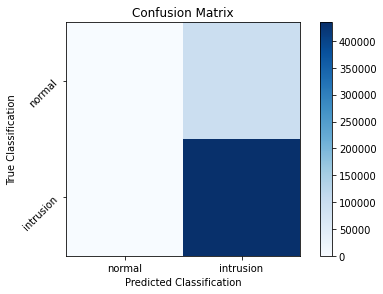

              precision    recall  f1-score   support

      normal     1.0000    0.0077    0.0152     97395
   intrusion     0.8181    1.0000    0.8999    434574

    accuracy                         0.8183    531969
   macro avg     0.9090    0.5038    0.4576    531969
weighted avg     0.8514    0.8183    0.7379    531969



In [25]:

# compute confusion matrix
true_output = numpy.argmax(tf_output['test'].to_numpy(), axis=1)
cm = confusion_matrix(true_output, predicted)

# display confusion matrix values
display(pandas.DataFrame(cm, columns=tf_output['test'].columns, index=tf_output['test'].columns))
# display a confusion matrix visualization
pyplot.figure()
pyplot.imshow(cm, interpolation='nearest', cmap=pyplot.cm.Blues)
pyplot.title("Confusion Matrix")
pyplot.colorbar()
tick_marks = numpy.arange(len(tf_output['test'].columns))
pyplot.xticks(tick_marks, tf_output['test'].columns)
pyplot.yticks(tick_marks, tf_output['test'].columns, rotation = 45)
pyplot.tight_layout()
pyplot.ylabel('True Classification')
pyplot.xlabel('Predicted Classification')
pyplot.show()

# print error scoring
print(classification_report(
    true_output, predicted,
    digits=4,
    target_names=tf_output['test'].columns
))

### Feature Importance

<hr style="border-top: 2px solid #444">

## VI. Conclusion